# 遗传算法 Genetic Algorithm

xyfJASON

## 1 概述

遗传算法是一种模拟自然选择和自然遗传机制的优化算法。在算法中，我们称一个可行解为一个**个体**，许多可行解构成一个**种群**。我们需要将每个可行解（即每个个体）**编码**成一个向量，而向量也能被**解码**称一个可行解，称这个向量为**染色体**。也就是说，这个向量中的每个数就好比染色体上的碱基对。众所周知，染色体可以**交叉互换**，其上的碱基对也可以发生**变异**，在遗传算法中，交叉互换的意义在于产生更优解，而变异的意义在于跳出局部最优解。

综上，遗传算法的步骤如下：

1. 设定种群大小、进化的代数、交叉互换率、变异率
2. 确定编码解码规则，设定适应度函数，设定初始种群
3. 当前种群进行交叉互换和变异
4. 按照适者生存机制选择新一代种群，即适应度越高，有越大概率被选中
5. 重复 3、4 步直至达到进化代数

## 2 代码模板

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


class GeneticAlgorithm:
    """
    To run genetic algorithms, inherit this class, then
    override `gen_init_population_code`, `calc_fitness` and `mutate`.
    Override `crossover` if needed.
    """
    def __init__(self,
                 sz_population: int,
                 n_generations: int,
                 rate_cross: float,
                 rate_mutate: float) -> None:
        """
        :param sz_population: size of population (number of individuals)
        :param n_generations: number of generations to evolve
        :param rate_cross: crossing over rate
        :param rate_mutate: mutation rate
        """
        self.sz_population = sz_population
        self.n_generations = n_generations
        self.rate_cross = rate_cross
        self.rate_mutate = rate_mutate
        self.init_population_code = self.gen_init_population_code()

    def gen_init_population_code(self):
        raise NotImplementedError

    def calc_fitness(self, population_code) -> np.ndarray:
        """ Calculate the fitness of a population.
        Better individuals have higher fitness scores.
        """
        raise NotImplementedError

    def mutate(self, code: np.ndarray) -> np.ndarray:
        """ Define the mutation process of an individual.
        Given an coded individual, return the mutated version of it.
        """
        raise NotImplementedError

    def crossover(self, code1: np.ndarray, code2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """ Define the crossing over process between two individuals.
        Given two coded individuals, return the crossed version of them.
        Can be overrided if needed.
        """
        assert len(code1.shape) == len(code2.shape) == 1
        assert code1.shape[0] == code2.shape[0]
        pos = np.random.randint(0, code1.shape[0])
        result1 = np.concatenate((code1[:pos], code2[pos:]))
        result2 = np.concatenate((code2[:pos], code1[pos:]))
        return result1, result2

    def crossover_and_mutate(self, population_code: np.ndarray) -> np.ndarray:
        assert len(population_code.shape) == 2
        next_population_code = []
        for code in population_code:
            new_code = code.copy()
            if np.random.rand() <= self.rate_cross:
                code2 = population_code[np.random.randint(0, self.sz_population)]
                new_code, _ = self.crossover(code, code2)
            if np.random.rand() <= self.rate_mutate:
                new_code = self.mutate(new_code)
            next_population_code.append(new_code)
        return np.array(next_population_code)

    def select(self, population_code: np.ndarray, fitness: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        assert len(population_code.shape) == 2 and len(fitness.shape) == 1
        assert population_code.shape[0] == fitness.shape[0]
        # idx = np.argsort(-fitness)[:self.sz_population]
        idx = np.random.choice(population_code.shape[0],
                               size=self.sz_population,
                               replace=True,
                               p=(fitness / fitness.sum()))
        return population_code[idx], fitness[idx]

    def run(self) -> tuple[np.ndarray, np.ndarray]:
        """
        :return: final population and fitness
        """
        cur_population_code = self.init_population_code
        for _ in tqdm(range(self.n_generations)):
            next_population_code = self.crossover_and_mutate(cur_population_code)
            cur_population_code = np.concatenate((cur_population_code, next_population_code))
            fitness = self.calc_fitness(cur_population_code)
            cur_population_code, cur_fitness = self.select(cur_population_code, fitness)
        return cur_population_code, self.calc_fitness(cur_population_code)

## 3 例题

### 3.1 例一——旅行商问题 (TSP)

http://www.math.uwaterloo.ca/tsp/vlsi/index.html

遗传算法解 TSP 问题：

- 设定编码规则为：将访问的城市编号顺序列出，即作为编码向量
- 设定适应度函数：由于距离越短说明结果越好，我将适应度设置为距离的相反数，随后对种群进行了归一化；也有其他多种定义方式
- 设定交叉互换规则：PMX 等
- 设定变异规则：任选两位置，翻转中间的城市序号

遗传算法似乎不是很擅长解决 TSP 问题（也可能是我的打开方式不太对），下面的代码仅求解 30 个点，当点数较大时，遗传算法得到的解的质量很差。

代码如下：

100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.72it/s]


[24 25 29 28 26 14 13 17 12  4  0 11  5 20 21 23 22 10  9  3  1  2  6  7
  8 19 27 18 15 16] 203.17788579798264


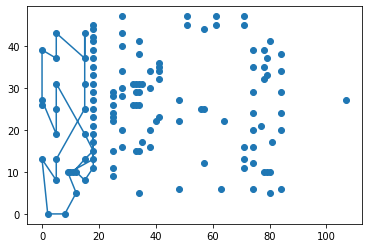

In [2]:
def TSP():
    """
    For this problem, the best result is 564
    refer to https://www.math.uwaterloo.ca/tsp/vlsi/xqf131.tour.html
    """
    with open('tsp_data.txt') as f:
        data = [list(map(int, line.strip().split())) for line in f.readlines()]
        data = np.array(data)
    n = 30

    def distance(_i, _j):
        """ distance between the ith row and the jth row """
        return np.sqrt((data[_i, 1] - data[_j, 1]) ** 2 + (data[_i, 2] - data[_j, 2]) ** 2)

    def evaluate(state: np.ndarray) -> float:
        assert len(state.shape) == 1
        dist = 0.0
        for i in range(state.shape[0]):
            j = (i + 1) % state.shape[0]
            dist += distance(state[i], state[j])
        return dist

    class Solver(GeneticAlgorithm):
        def gen_init_population_code(self) -> np.ndarray:
            states = []
            for k in range(self.sz_population):
                best_init_state, best_init_dist = np.arange(n), np.inf
                for _ in range(10):
                    init_state = np.random.permutation(n)
                    init_dist = evaluate(init_state)
                    if init_dist < best_init_dist:
                        best_init_state, best_init_dist = init_state, init_dist
                states.append(best_init_state)
            return np.array(states)

        def calc_fitness(self, population_code) -> np.ndarray:
            assert len(population_code.shape) == 2
            dists = np.array([evaluate(pop) for pop in population_code])
            fitness = (np.max(dists) - dists) / (np.max(dists) - np.min(dists) + 1e-6)
            return fitness

        def mutate(self, code: np.ndarray) -> np.ndarray:
            assert len(code.shape) == 1
            u, v = np.random.choice(code.shape[0]+1, 2, replace=False)
            u, v = (v, u) if u > v else (u, v)
            mutate_code = code.copy()
            mutate_code[u:v] = mutate_code[u:v][::-1]  # [u, v)
            return mutate_code

        def crossover(self, code1: np.ndarray, code2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
            """ PMX """
            assert len(code1.shape) == len(code2.shape) == 1
            assert code1.shape[0] == code2.shape[0]
            u, v = np.random.choice(code1.shape[0]+1, size=2, replace=False)
            u, v = (v, u) if u > v else (u, v)
            result1, result2 = code1.copy(), code2.copy()
            result1[u:v] = code2[u:v]; result2[u:v] = code1[u:v]
            while True:
                ok = True
                for i in range(code1.shape[0]):
                    if u <= i < v:
                        continue
                    if result1[i] in code2[u:v].tolist():
                        result1[i] = code1[np.where(code2 == result1[i])[0]]
                        ok = False
                    if result2[i] in code1[u:v].tolist():
                        result2[i] = code2[np.where(code1 == result2[i])[0]]
                        ok = False
                if ok:
                    break
            return result1, result2

    solver = Solver(sz_population=50,
                    n_generations=1000,
                    rate_cross=1,
                    rate_mutate=0.1)
    res = solver.run()
    res = res[0][res[1].argmax()]
    print(res, evaluate(res))

    def plot_route(res_state):
        fig, ax = plt.subplots(1, 1)
        ax.scatter(data[:, 1], data[:, 2])
        ax.plot(np.hstack((data[res_state, 1], data[res_state[0:1], 1])),
                np.hstack((data[res_state, 2], data[res_state[0:1], 2])))
        plt.show()

    plot_route(res)
    

TSP()

### 3.2 例二

求下列函数在 $[-3,3]^2$ 上的最大值：
$$
F(x,y)=3(1-x)^2e^{-x^2-(y+1)^2}-10\left(\frac{x}{5}-x^3-y^5\right)e^{-x^2-y^2}-\frac{1}{3}^{\exp\left(-(x+1)^2-y^2\right)}
$$

- 设定编码规则为：将数字缩放到 $[0,1]$ 区间中，表示为二进制小数，随后取小数点后 24 位构成 01 向量作为编码
- 设定适应度函数：函数值减去最小函数值
- 设定交叉互换规则：从某一位置后互换
- 设定变异规则：随机改变 01 向量的某一位（0 变 1，1 变 0）

代码如下：

In [3]:
def F(x, y):
    return 3*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1/3**np.exp(-(x+1)**2-y**2)

def decoder(code: np.ndarray) -> tuple[float, float]:
    x, y = 0, 0
    for i in range(24):
        x = x * 2 + code[i]
    for i in range(24, 48):
        y = y * 2 + code[i]
    x /= (1 << 24); y /= (1 << 24)
    return x * 6 - 3, y * 6 - 3

class Solver(GeneticAlgorithm):
    def gen_init_population_code(self) -> np.ndarray:
        return np.vstack(np.random.randint(0, 2, (self.sz_population, 48)))

    def calc_fitness(self, population_code: np.ndarray) -> np.ndarray:
        fitness = np.array([F(*decoder(code)) for code in population_code])
        return fitness - np.min(fitness) + 1e-6

    def mutate(self, code: np.ndarray) -> np.ndarray:
        pos = np.random.randint(0, 44)
        newcode = code.copy()
        newcode[pos] = 1 - newcode[pos]
        return newcode

solver = Solver(sz_population=50,
                n_generations=1000,
                rate_cross=0.95,
                rate_mutate=0.1)
res = solver.run()
print(decoder(res[0][res[1].argmax()]),
      F(*decoder(res[0][res[1].argmax()])))

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 272.85it/s]

(-0.016335010528564453, 1.5696687698364258) 7.1493153003465


作图如下：
![](img/ga.png)